# CISC/CMPE 452/COGS 400 Assignment 1 - Perceptron (10 points)  

Please put your name and student id here

    Mile Stosic , #20233349

- The notebook file has clearly marked blocks where you are expected to write code. Do not write or modify any code outside of these blocks.
- Make sure to restart and run all the cells from the beginning before submission. Do not clear out the outputs.
- Mark will be deducted based on late policy (-1% of the course total marks per day after due date until the end date after which no assignments will be accepted)



### Build Model (6 points)  
Implement **Simple Feedback Learning** for emotion classification (dataset from: https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp)

Use the correct/incorrect feedback and info about (y>d) or (y<d) to change weights.  
Refer to the **Perceptron slides**  

- 1. Implement forward and calculate the output (2 point)  
- 2. Update the weights and bias (2 points)  
- 3. Predict function (1 point)  
- 4. Activation function (1 point)  

### Evaluator Function (2 point)  
Implement the evaluator function with Pytorch or Numpy only   
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

### Train and Evaluate the Model (2 point)  
Train the model with customized learning rate and number of iterations  
Use the predict function to predict the labels with the test dataset  
Evaluate the prediction results  
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score


In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [259]:
# load dataset
# Define the file paths using the variable
file_path = "C:/Users/miles/OneDrive - Queen's University/Eng Year 4 - 2024/CMPE 452/Assignment #1/data/data/"
train_file = file_path + "train.txt"
test_file = file_path + "test.txt"

# Read the train and test files into dataframes
df_train = pd.read_csv(train_file, names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv(test_file, names=['Text', 'Emotion'], sep=';')

In [260]:
x_train = df_train['Text']
y_train = df_train['Emotion']

x_test = df_test['Text']
y_test = df_test['Emotion']

df_train.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [261]:
df_train.Emotion.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64

## Data Preprocessing

In [262]:
# encode label
y_train = y_train.replace({'joy':1, 'sadness':0, 'anger':0, 'fear':0, 'love':1, 'surprise':1})
y_test = y_test.replace({'joy':1, 'sadness':0, 'anger':0, 'fear':0, 'love':1, 'surprise':1})

In [263]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5)#, stop_words='english')

# We transform each text into a vector
x_train = tfidf.fit_transform(x_train).toarray()
x_test = tfidf.transform(x_test).toarray()

In [264]:
def evaluator(y_test, y_pred):
    # Initialize variables for the confusion matrix
    true_positive = 0 
    false_positive = 0
    true_negative = 0
    false_negative = 0

    # Calculate confusion matrix
    for i in range(len(y_test)):
        if y_test[i] == 1 and y_pred[i] == 1:
            true_positive += 1
        elif y_test[i] == 0 and y_pred[i] == 1:
            false_positive += 1
        elif y_test[i] == 0 and y_pred[i] == 0:
            true_negative += 1
        elif y_test[i] == 1 and y_pred[i] == 0:
            false_negative += 1

    # Calculate accuracy
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
    # Calculate precision
    precision = true_positive / (true_positive + false_positive)
    # Calculate recall
    recall = true_positive / (true_positive + false_negative)
    # Calculate F1-score
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Return the calculated metrics
    return {
        "Confusion Matrix": {
            "True Positive": true_positive,
            "False Positive": false_positive,
            "True Negative": true_negative,
            "False Negative": false_negative,
        },
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score,
    }

In [265]:
class SimpleFeedbackLearning(object):
    def __init__(self):
        self.history = {}
        self.history['train_acc'] = []
        self.history['test_acc'] = []
        
    def f(self, x):
            # Activation function (e.g., ReLU)
            fx = np.maximum(0, x)
            return fx
        
    def train(self, x, y, x_test, y_test, learning_rate=0.1, n_iters=10, verbose=True):
        n_train, input_size = x.shape
        n_test = x_test.shape[0]
        # weight initialization
        self.W = np.zeros(input_size)
        self.b = np.zeros(1)

        for i in range(n_iters):
            for xi, yi in zip(x, y):
                # Forward
                output = np.dot(xi, self.W) + self.b
                a = self.f(output)
                # Calculate prediction error
                error = a - yi

                # Adjust weights based on feedback
                # # Predicted output is greater than actual
                if error > 0:  
                    self.W -= learning_rate * xi
                    self.b -= learning_rate
                # Predicted output is less than actual
                elif error < 0:  
                    self.W += learning_rate * xi
                    self.b += learning_rate

            train_acc = (self.predict(x) == y).sum() / n_train
            test_acc = (self.predict(x_test) == y_test).sum() / n_test
            self.history['train_acc'].append(train_acc)
            self.history['test_acc'].append(test_acc)
            if verbose:
                print('epoch %d, train acc %.4f, test acc %.4f' % (i + 1, train_acc, test_acc))

    def predict(self, x):
        # Use the trained weights to predict labels and return the predicted labels
        output = np.dot(x, self.W) + self.b
        y_pred = np.round(self.f(output))
        return y_pred

In [266]:
####################################################################################################
# enter code here to initialize and train the model
# Initialize the model
model1 = SimpleFeedbackLearning()
# Hyperparameters
learning_rate = 0.01
n_iters = 20
# Train the model
model1.train(x_train, y_train, x_test, y_test, learning_rate=learning_rate, n_iters=n_iters, verbose=True)
####################################################################################################


epoch 1, train acc 0.5534, test acc 0.5450
epoch 2, train acc 0.7373, test acc 0.7250
epoch 3, train acc 0.8684, test acc 0.8625
epoch 4, train acc 0.9137, test acc 0.9050
epoch 5, train acc 0.9262, test acc 0.9245
epoch 6, train acc 0.9266, test acc 0.9240
epoch 7, train acc 0.9379, test acc 0.9350
epoch 8, train acc 0.9472, test acc 0.9420
epoch 9, train acc 0.9516, test acc 0.9425
epoch 10, train acc 0.9569, test acc 0.9460
epoch 11, train acc 0.9584, test acc 0.9475
epoch 12, train acc 0.9583, test acc 0.9500
epoch 13, train acc 0.9571, test acc 0.9495
epoch 14, train acc 0.9592, test acc 0.9505
epoch 15, train acc 0.9593, test acc 0.9495
epoch 16, train acc 0.9622, test acc 0.9510
epoch 17, train acc 0.9619, test acc 0.9520
epoch 18, train acc 0.9623, test acc 0.9510
epoch 19, train acc 0.9625, test acc 0.9510
epoch 20, train acc 0.9627, test acc 0.9510


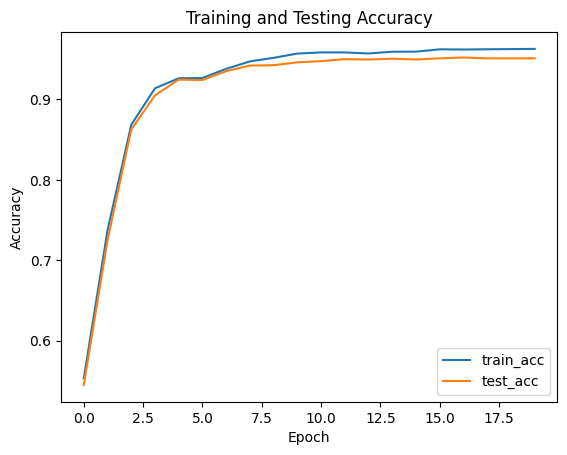

In [267]:
# Plot the accuracy
plt.plot(model1.history['train_acc'], label='train_acc')
plt.plot(model1.history['test_acc'], label='test_acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.show()

In [268]:
####################################################################################################
# enter code here to evaluate the model with the evaluator function
# Evaluate the model on the test data
y_pred = model1.predict(x_test)
results = evaluator(y_test, y_pred)

# Print the evaluation results
print("Evaluation Results:")
print("Confusion Matrix:")
print("True Positive:", results['Confusion Matrix']['True Positive'])
print("False Positive:", results['Confusion Matrix']['False Positive'])
print("True Negative:", results['Confusion Matrix']['True Negative'])
print("False Negative:", results['Confusion Matrix']['False Negative'])
print("Accuracy:", results['Accuracy'])
print("Precision:", results['Precision'])
print("Recall:", results['Recall'])
print("F1-Score:", results['F1-Score'])

####################################################################################################

Evaluation Results:
Confusion Matrix:
True Positive: 844
False Positive: 22
True Negative: 1058
False Negative: 65
Accuracy: 0.9562594268476622
Precision: 0.9745958429561201
Recall: 0.9284928492849285
F1-Score: 0.9509859154929577
